In [31]:
import glob
import os
import librosa
import librosa.display
import skimage
import numpy as np
import pandas as pd

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 



In [13]:
metadata = pd.read_csv("UrbanSound8k/metadata/UrbanSound8K.csv")
metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


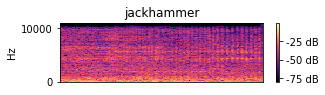

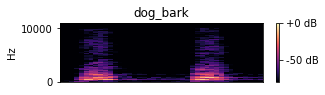

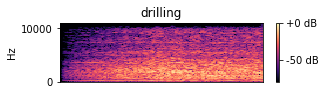

In [18]:
arr = np.array(metadata["slice_file_name"])
fold = np.array(metadata["fold"])
cla = np.array(metadata["class"])

for i in range(192, 197, 2):
    path = 'UrbanSound8k/audio/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

In [22]:
feature = []
label = []

def parser(row):
    # Function to load files and extract features
    for i in range(8732):
        file_name = 'UrbanSound8k/audio/fold' + str(metadata["fold"][i]) + '/' + metadata["slice_file_name"][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        # We extract mfcc feature from data
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        feature.append(mels)
        label.append(metadata["classID"][i])
    return [feature, label]

In [59]:
temp = parser(metadata)
temp = np.array(temp)
data = temp.transpose()

C:\Users\Chris\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
C:\Users\Chris\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\Users\Chris\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
<ipython-input-59-0fabb63ec721>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  temp = np.array(temp)


In [54]:
data1 = pd.DataFrame(data)
data1 = data1.rename(columns={0: "MFCC", 1: "Fold"})
data1 = data1.sort_values(by=['Fold'])
data1.to_csv('UrbanSound8k_MFCC.csv')

In [60]:
X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)
X = np.empty([8732, 128])

(17464,) (17464,)


In [25]:
for i in range(8732):
    X[i] = (X_[i])

In [26]:
Y = to_categorical(Y)

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)

In [35]:
X_train = X_train.reshape(6549, 16, 8, 1)
X_test = X_test.reshape(2183, 16, 8, 1)
input_dim = (16, 8, 1)

In [36]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1024, activation = "tanh"))
model.add(Dense(10, activation = "softmax"))

In [37]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [38]:
model.fit(X_train, Y_train, epochs = 90, batch_size = 50, validation_data = (X_test, Y_test))

Epoch 1/90
131/131 [==============================] - 3s 15ms/step - loss: 1.5214 - accuracy: 0.4804 - val_loss: 1.2752 - val_accuracy: 0.5754
Epoch 2/90
131/131 [==============================] - 2s 13ms/step - loss: 1.1331 - accuracy: 0.6209 - val_loss: 1.1617 - val_accuracy: 0.6290
Epoch 3/90
131/131 [==============================] - 2s 13ms/step - loss: 0.9556 - accuracy: 0.6760 - val_loss: 1.1040 - val_accuracy: 0.6436
Epoch 4/90
131/131 [==============================] - 2s 13ms/step - loss: 0.8653 - accuracy: 0.7125 - val_loss: 0.9514 - val_accuracy: 0.7100
Epoch 5/90
131/131 [==============================] - 2s 13ms/step - loss: 0.7515 - accuracy: 0.7490 - val_loss: 0.9412 - val_accuracy: 0.7155
Epoch 6/90
131/131 [==============================] - 2s 16ms/step - loss: 0.6618 - accuracy: 0.7838 - val_loss: 0.9058 - val_accuracy: 0.7306
Epoch 7/90
131/131 [==============================] - 2s 14ms/step - loss: 0.6495 - accuracy: 0.7838 - val_loss: 0.9175 - val_accuracy: 0.7311

Epoch 58/90
131/131 [==============================] - 2s 16ms/step - loss: 0.0847 - accuracy: 0.9696 - val_loss: 0.8077 - val_accuracy: 0.8548
Epoch 59/90
131/131 [==============================] - 2s 14ms/step - loss: 0.0748 - accuracy: 0.9748 - val_loss: 0.8487 - val_accuracy: 0.8612
Epoch 60/90
131/131 [==============================] - 2s 14ms/step - loss: 0.0810 - accuracy: 0.9736 - val_loss: 0.7553 - val_accuracy: 0.8649
Epoch 61/90
131/131 [==============================] - 2s 14ms/step - loss: 0.0769 - accuracy: 0.9747 - val_loss: 0.7693 - val_accuracy: 0.8571
Epoch 62/90
131/131 [==============================] - 2s 14ms/step - loss: 0.0834 - accuracy: 0.9725 - val_loss: 0.8275 - val_accuracy: 0.8516
Epoch 63/90
131/131 [==============================] - 2s 17ms/step - loss: 0.0830 - accuracy: 0.9713 - val_loss: 0.8672 - val_accuracy: 0.8475
Epoch 64/90
131/131 [==============================] - 2s 15ms/step - loss: 0.0884 - accuracy: 0.9698 - val_loss: 0.9000 - val_accuracy:

In [55]:
predictions = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print(score)

69/69 [==============================] - 0s 5ms/step - loss: 0.9449 - accuracy: 0.8525
[0.9449069499969482, 0.8524965643882751]


In [56]:
preds = np.argmax(predictions, axis = 1)

In [57]:
preds

array([2, 8, 8, ..., 2, 4, 3], dtype=int64)